# Classification de séquences protéiques en localisations subcellulaires (MultiLoc)
Louise LAM (21980795) - M2BI

## Importations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas import read_csv
import requests
from tqdm import tqdm
import zipfile

# keras
from keras.callbacks import EarlyStopping
from keras.layers import Activation, Add, BatchNormalization, Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D, AveragePooling1D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.utils import plot_model, to_categorical

import seaborn as sns

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# tensorflow
from tensorflow.keras import optimizers
import tensorflow as tf

## Loading data

In [3]:
def download_data():
    """Download the data associated with the github repository."""
    url="https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Download the zip file if it does not exist
    if not os.path.exists(FilePath):
        download_file(url, FilePath)

In [4]:
# Download data from the github repository
download_data()

dataset/reduced_train.npz: 100%|██████████| 8.52M/8.52M [00:00<00:00, 116MB/s]


In [5]:
# Extracting X and Y
file_data = "dataset/reduced_train.npz"
data = np.load(file_data)
X = data["X_train"]
Y = data["y_train"]
print("Shape of dataset X")
print(X.shape)
print("Shape of dataset Y")
print(Y.shape)

Shape of dataset X
(2423, 400, 20)
Shape of dataset Y
(2423,)


In [6]:
# Label encoding
classes = LabelEncoder()
classes.fit(Y)
Y_classes = classes.transform(Y)

print("First 3 rows of X:\n", X[:3])
print("\nFirst 3 elements of Y (original):\n", Y[:3])

First 3 rows of X:
 [[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]]

First 3 elements of Y (original):
 [6 6 6]


In [7]:
# Statistics for the first feature across all samples and time points
df = pd.DataFrame(X[:, :, 0])
stats = df.describe()
print(stats)

               0            1            2            3            4    \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000   
mean      0.021865     0.205510     0.099270     0.075233     0.088902   
std       0.114765     0.298014     0.175479     0.142319     0.156582   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.050000     0.020000     0.020000     0.030000   
75%       0.000000     0.300000     0.120000     0.090000     0.100000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               5            6            7            8            9    ...  \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000  ...   
mean      0.085184     0.093553     0.089930     0.100896     0.099030  ...   
std       0.145490     0.159008     0.150393     0.156734     0.152685  ...   
min       0.00000

In [8]:
# Creating train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3, shuffle=True)

In [9]:
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
print("\nFirst 3 rows of one-hot encoded Y train:\n", y_train_oh[:3])
print("\nFirst 3 rows of one-hot encoded Y test:\n", y_train_oh[:3])


First 3 rows of one-hot encoded Y train:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

First 3 rows of one-hot encoded Y test:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Sample verification

In [10]:
print('Shapes of datasets')
print(f'train: {X_train.shape}')
print(f'test: {X_test.shape}')
nb_classes = len(set(Y))
print(f'For {nb_classes} classes: {set(Y)}')

Shapes of datasets
train: (1938, 400, 20)
test: (485, 400, 20)
For 10 classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


**Taille des échantillons** : les échantillons sont sufisamment remplis.

In [11]:
print('Coherence between the number of sequences and labels')
print(f'train: {X_train.shape[0] == len(y_train)}')
print(f'test: {X_test.shape[0] == len(y_test)}')

print('\nMissing values?')
print(f'train: {np.any(np.isnan(y_train))}')
print(f'test: {np.any(np.isnan(y_test))}')

Coherence between the number of sequences and labels
train: True
test: True

Missing values?
train: False
test: False


**Cohérence entre les séquences et les *labels*** : Chaque séquence a son *label*.

Label distribution:
All labels are represented in both train and test samples.


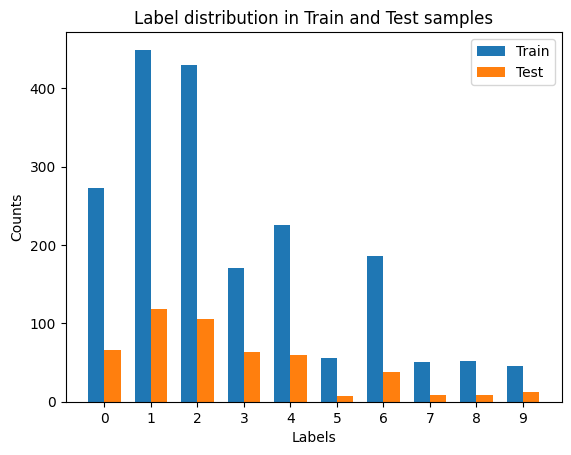

In [12]:
def display_label_distribution():
  """Display the label distribution in both train and test samples."""

  y_train_set, y_train_counts = np.unique(y_train, return_counts=True)
  y_test_set, y_test_counts = np.unique(y_test, return_counts=True)

  # Check if all labels are represented in both samples
  if set(y_train_set) != set(y_test_set):
      print('Error: Not all labels are represented in train and test samples.')
      return
  print('All labels are represented in both train and test samples.')

  # Bars configuration
  bar_width = 0.35
  x = np.arange(len(y_train_set))
  # Bars for train and test samples
  plt.bar(x - bar_width / 2, y_train_counts, width=bar_width, label='Train')
  plt.bar(x + bar_width / 2, y_test_counts, width=bar_width, label='Test')
  # Adding labels and title
  plt.xlabel('Labels')
  plt.ylabel('Counts')
  plt.title('Label distribution in Train and Test samples')
  plt.xticks(x, y_train_set)  # Labels for the x-axis
  plt.legend()
  plt.show()

print('Label distribution:')
display_label_distribution()

**Distribution des *labels*** : Toutes les classes sont représentées dans les échantillons de train et de test. En revanche, notons que les classes sont déséquilibrées (*unbalanced classes*) au sein des échantillons.

In [13]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 0.7125, 1: 0.4316258351893096, 2: 0.45069767441860464, 3: 1.14, 4: 0.8575221238938053, 5: 3.460714285714286, 6: 1.0419354838709678, 7: 3.8, 8: 3.726923076923077, 9: 4.21304347826087}



Il est essentiel de prendre en compte ce déséquilibre lors de l'apprentissage. C'est pourquoi nous allons attribuer des poids à nos classes : les moins représentées auront des poids plus forts tandis que les plus représentées auront des poids plus faibles.

In [14]:
def display_n_sequences(n: int, sample: str):
    """Display the first n sequences with their labels.

    Parameters
    ----------
    n : int
        Number of sequences to display.
    sample : str
        Either 'train' or 'test'.
    """
    sequences = X_train if sample == 'train' else X_test
    labels = y_train if sample == 'train' else y_test
    print(f'First {n} sequences of the {sample} set:')
    for i in range(n):
        print(f'Sequence {i + 1}: {sequences[i]}')
        print(f'Label: {labels[i]}\n')

display_n_sequences(3, 'train')
display_n_sequences(3, 'test')

First 3 sequences of the train set:
Sequence 1: [[0.   0.   0.   ... 0.   0.   0.  ]
 [0.37 0.03 0.   ... 0.   0.   0.03]
 [0.09 0.23 0.03 ... 0.   0.   0.08]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
Label: 2

Sequence 2: [[0.   0.   0.   ... 0.   0.   0.23]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.06 0.2  0.14 ... 0.   0.   0.03]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
Label: 1

Sequence 3: [[0.   0.   0.   ... 0.   0.   0.  ]
 [1.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.34 0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
Label: 3

First 3 sequences of the test set:
Sequence 1: [[0.   0.   0.   ... 0.   0.   0.27]
 [0.05 0.   0.16 ... 0.   0.   0.  ]
 [0.01 0.03 0.27 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.

## CNN

J'ai repris l'architecture du CNN utilisé pour MNIST (petit projet) car il avait donné de bons résultats. Cependant, j'ai constaté quelques problèmes :
- Convergence : Le modèle converge moins bien, affichant une précision réduite et une augmentation de la loss. Pour remédier à cela, j'ai ajouté une couche de convolution et augmenté progressivement le nombre de filtres. J'ai également abaissé le learning rate pour converger plus finement en évitant les oscillations. De plus, étant donné que nous avons un jeu de données relativement petit, j'ai décidé de réduire la taille des batchs à 32 au lieu de 128. Cette modification a considérablement amélioré la précision de mon réseau.
- Sur-apprentissage : Un fort sur-apprentissage était présent. Pour y faire face, j'ai augmenté le pourcentage de dropout à 40 % et ajouté des régularisateurs L2 aux couches de convolution ainsi qu'à la couche dense. J'ai aussi opté pour un nombre d'epochs élevé, tout en intégrant un *early stopping*. Cela permettra de stopper l'entraînement lorsque la performance sur le jeu de validation ne s'améliore plus, évitant ainsi le sur-apprentissage et garantissant que le modèle reste capable de généraliser efficacement sur des données non vues.

### Architecture

In [15]:
def cnn_simple():
  """Build and return a simple CNN model for sequence classification.

  Returns
  -------
  Sequential
    The compiled Keras Sequential model.
  """
  # Build the model
  model = Sequential()
  # First convolution layer with 64 filters, ReLU activation
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(400, 20), kernel_regularizer=l2(0.001)))
  model.add(MaxPooling1D(2))
  # Second convolution layer with 128 filters, ReLU activation
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(MaxPooling1D(2))
  # Third convolution layer with 256 filters, ReLU activation
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(MaxPooling1D(2))
  model.add(Dropout(0.4))
  # From 2D to 1D
  model.add(Flatten())
  # Better accuracy
  model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.4)) # regularization
  # Output layer
  model.add(Dense(10, activation='softmax'))
  # Compiling
  opt = optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 398, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 199, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 197, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 96, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 48, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         786,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 914,314 (3.49 MB)

 Trainable params: 914,314 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

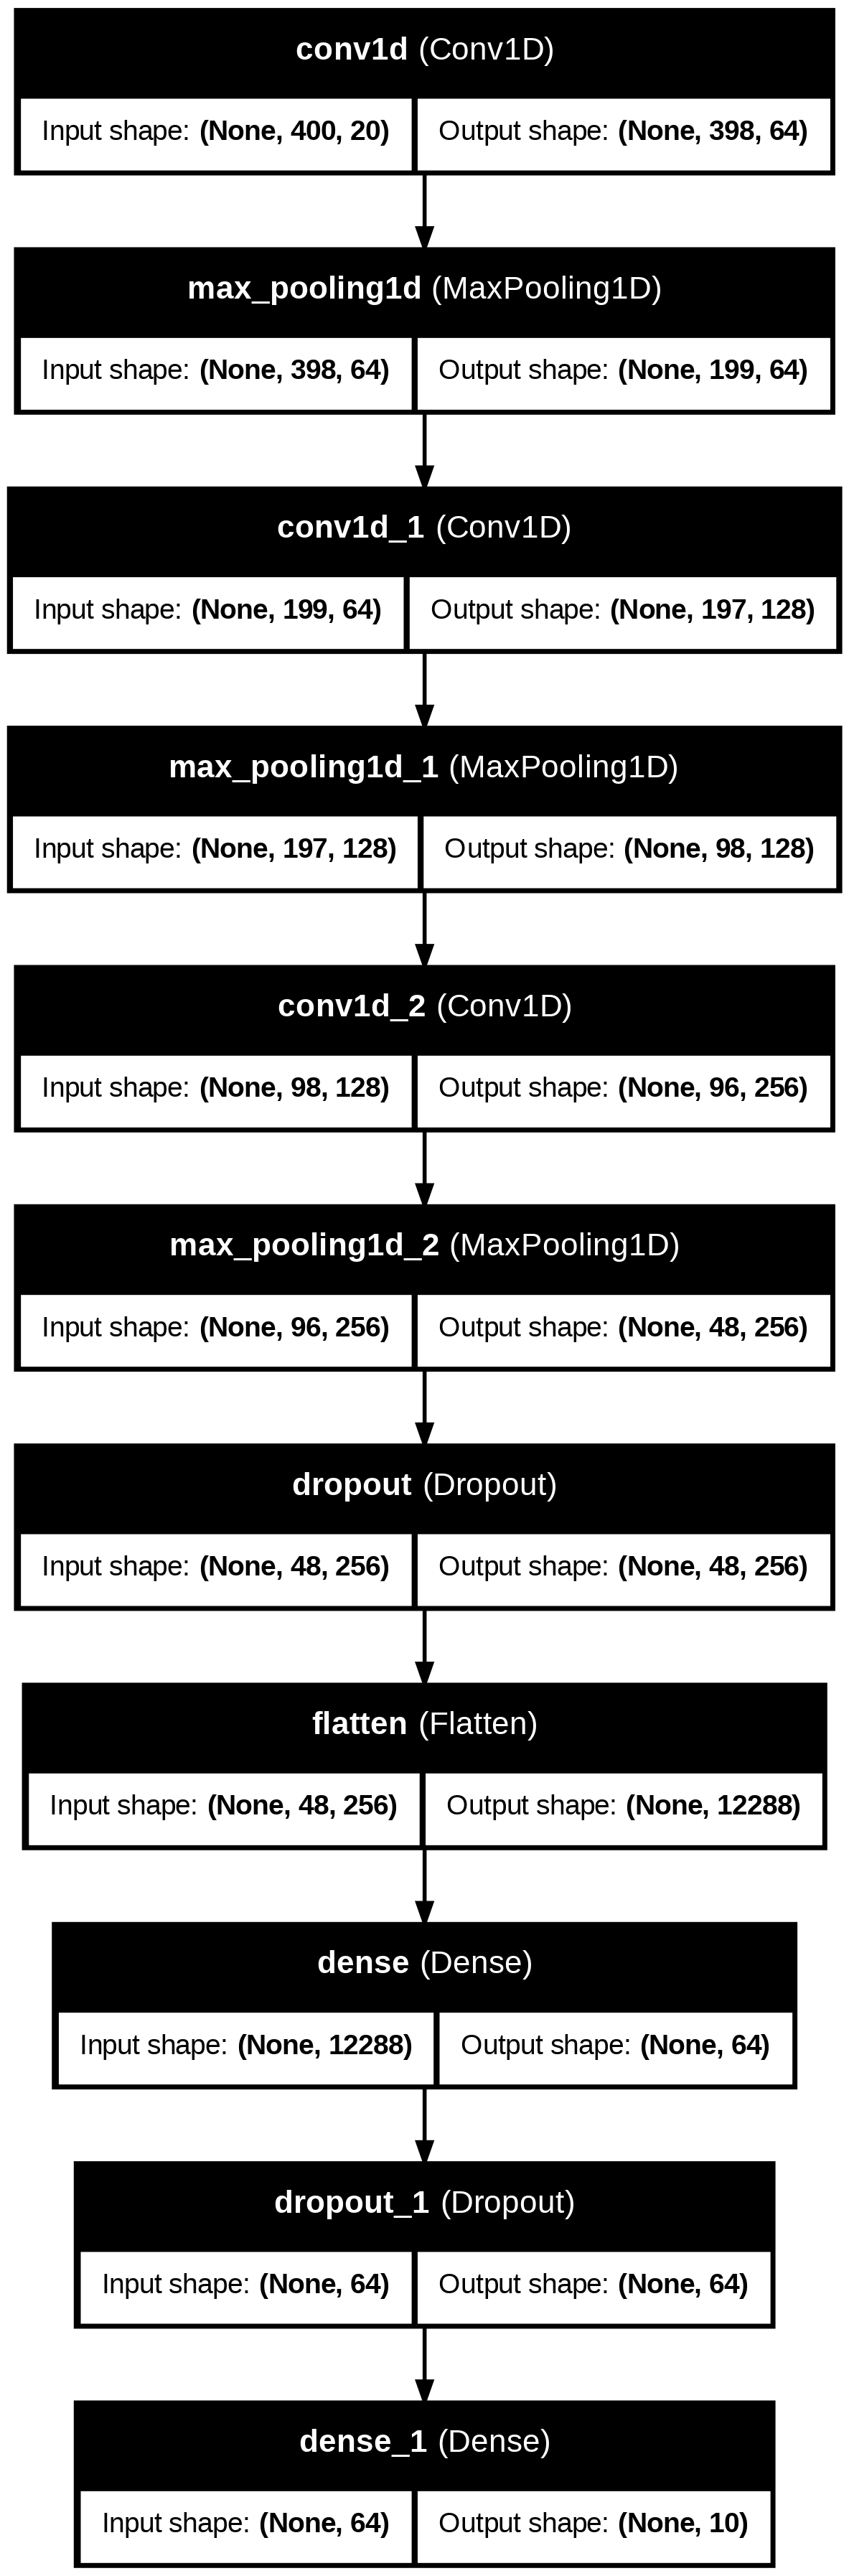

In [16]:
cnn_model = cnn_simple()
cnn_model.summary()
plot_model(cnn_model, to_file="cnn_model.png", show_shapes=True, show_layer_names=True)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_history = cnn_model.fit(X_train, y_train_oh, validation_split=0.2, epochs=70, batch_size=32, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.1194 - loss: 2.7644 - weighted_accuracy: 0.0961 - val_accuracy: 0.2371 - val_loss: 2.7318 - val_weighted_accuracy: 0.2371
Epoch 2/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2289 - loss: 2.6409 - weighted_accuracy: 0.1975 - val_accuracy: 0.2320 - val_loss: 2.6433 - val_weighted_accuracy: 0.2320
Epoch 3/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2295 - loss: 2.6334 - weighted_accuracy: 0.2244 - val_accuracy: 0.2474 - val_loss: 2.5403 - val_weighted_accuracy: 0.2474
Epoch 4/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2477 - loss: 2.5709 - weighted_accuracy: 0.2547 - val_accuracy: 0.2887 - val_loss: 2.4794 - val_weighted_accuracy: 0.2887
Epoch 5/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2593 - loss: 2.5064 - weighted_accuracy: 0.2818 - val_accuracy: 0.3454 - val_loss: 2.3577 - val_weighted_accuracy: 0.3454
Epoch 6/70
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.330

In [18]:
cnn_scores = cnn_model.evaluate(X_test, y_test_oh)
print("Neural network accuracy: %.2f%%" % (cnn_scores[1] * 100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7708 - loss: 1.1514 - weighted_accuracy: 0.7708
Neural network accuracy: 78.97%


Le modèle semble quand même parvenir à apprendre et à généraliser sur le jeu de test.

### Performances

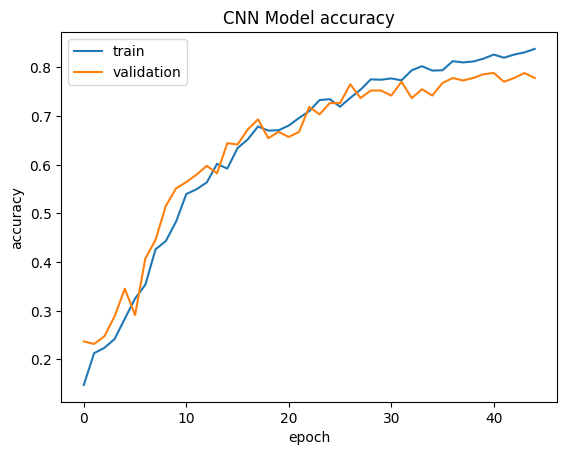

In [19]:
#  Accuracy
plt.plot(cnn_history.history["accuracy"])
plt.plot(cnn_history.history["val_accuracy"])
plt.title("CNN Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

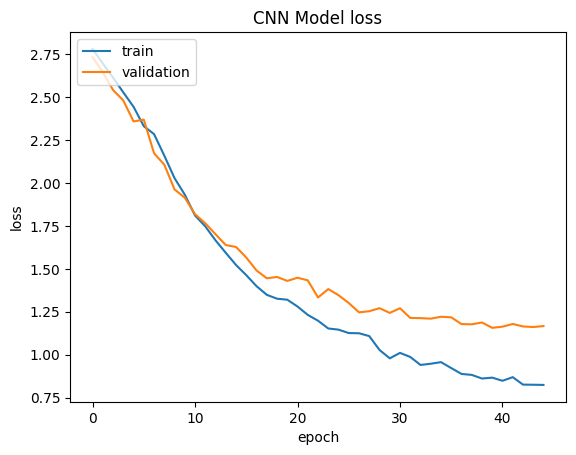

In [20]:
# Loss
plt.plot(cnn_history.history["loss"])
plt.plot(cnn_history.history["val_loss"])
plt.title("CNN Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

Ça converge moins vite mais j’ai réussi à diminuer drastiquement le fort overfitting.

In [21]:
cnn_y_pred = cnn_model.predict(X_test)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis = 1)
cnn_y_pred_classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


array([1, 1, 1, 1, 4, 2, 6, 1, 6, 6, 0, 2, 6, 0, 0, 4, 1, 6, 4, 6, 6, 1,
       4, 3, 0, 2, 2, 3, 2, 5, 1, 2, 0, 2, 2, 4, 4, 0, 1, 7, 6, 4, 7, 6,
       1, 1, 1, 1, 3, 7, 2, 0, 2, 2, 2, 2, 2, 7, 0, 0, 3, 2, 1, 1, 2, 0,
       0, 1, 3, 6, 0, 2, 1, 2, 0, 2, 3, 0, 2, 0, 0, 1, 8, 3, 1, 6, 4, 1,
       2, 7, 1, 6, 0, 4, 4, 1, 1, 7, 2, 5, 3, 0, 0, 2, 9, 4, 4, 1, 0, 8,
       1, 6, 3, 1, 1, 3, 6, 1, 4, 2, 3, 2, 2, 2, 5, 5, 3, 2, 0, 2, 0, 4,
       6, 0, 4, 1, 6, 1, 6, 6, 2, 4, 6, 2, 1, 1, 0, 8, 0, 1, 1, 0, 2, 0,
       2, 1, 2, 5, 3, 6, 4, 1, 6, 2, 0, 0, 0, 3, 4, 0, 1, 3, 4, 2, 4, 2,
       6, 7, 4, 0, 2, 9, 4, 4, 2, 2, 0, 1, 0, 6, 7, 1, 0, 3, 2, 1, 2, 6,
       1, 1, 7, 5, 4, 6, 0, 1, 1, 1, 8, 0, 1, 4, 2, 1, 3, 3, 1, 0, 4, 2,
       4, 4, 3, 6, 2, 0, 1, 6, 4, 2, 6, 2, 4, 1, 2, 1, 0, 7, 2, 3, 6, 3,
       2, 4, 2, 1, 2, 8, 6, 4, 1, 1, 0, 9, 1, 0, 2, 0, 4, 0, 0, 3, 2, 2,
       2, 0, 1, 3, 9, 6, 8, 4, 4, 0, 4, 2, 2, 1, 7, 1, 4, 4, 6, 6, 1, 4,
       1, 1, 2, 6, 9, 2, 2, 1, 4, 4, 0, 6, 3, 5, 4,

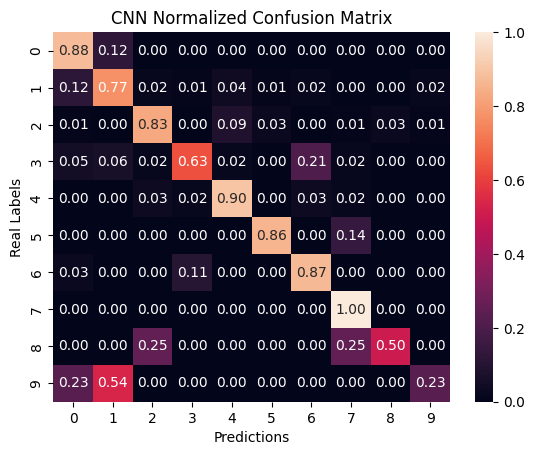

In [22]:
sns.heatmap(confusion_matrix(y_test, cnn_y_pred_classes, normalize="true"), annot=True, fmt='.2f')
plt.title("CNN Normalized Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Labels")
plt.show()

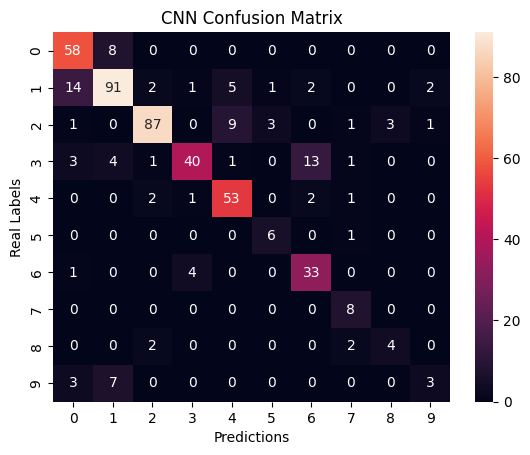

In [23]:
sns.heatmap(confusion_matrix(y_test, cnn_y_pred_classes), annot=True, fmt='d')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Labels")
plt.show()

Malgré les class weights, le modèle semble avoir du mal à bien étiqueter les classes sous-représentées.

### Cross Validation

In [99]:
def cnn_cv():
  """Compute cross-validation for the CNN model.

  Returns
  -------
  Tuple[int, int]
    A tuple containing the history list and test scores for each fold.
  """
  history_list  = []
  test_scores = []
  # StratifiedKFold to keep the classes proportions
  skf = StratifiedKFold(n_splits=5, shuffle=True)
  # for each fold
  for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_oh[train_index], y_train_oh[val_index]
    # build the model
    model = cnn_simple()
    # training
    print(f'\n========== FOLD {fold} ==========\n')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(x_train_fold, y_train_fold, validation_data=(x_val_fold, y_val_fold), epochs=100, batch_size=32, class_weight=class_weights, callbacks=[early_stopping])
    # Store results
    history_list.append(history.history)
    test_scores.append(model.evaluate(X_test, y_test_oh, verbose=0))
  return history_list, test_scores

def display_kfold_train_val_results(history_list, type):
  """Display the accuracy and loss curves for each fold.

  Parameters
  ----------
  history_list : List
    List of dictionaries containing training history for each fold.
  type : str
    Either 'CNN' or 'Resnet'.
  """
  plt.figure(figsize=(12, 5))
  # Accuracies
  plt.subplot(1, 2, 1)
  for i, history in enumerate(history_list):
      plt.plot(history['accuracy'], label=f'Fold {i + 1} (train)')
      plt.plot(history['val_accuracy'], label=f'Fold {i + 1} (val)', linestyle='--')
  plt.title(f'{type} accuracy per fold')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()
  # Losses
  plt.subplot(1, 2, 2)
  for i, history in enumerate(history_list):
      plt.plot(history['loss'], label=f'Fold {i + 1} (train)')
      plt.plot(history['val_loss'], label=f'Fold {i + 1} (val)', linestyle='--')
  plt.title(f'{type} loss per fold')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()

def display_kfold_test_results(test_scores):
  """Display the overall accuracy and loss on test sample for each fold.

  Parameters
  ----------
  test_scores : List
    List of tuples containing test scores for each fold.
  """
  test_losses = [scores[0] for scores in test_scores]
  test_accuracies = [scores[1] * 100 for scores in test_scores]  # percentages
  mean_accuracy = np.mean(test_accuracies)
  mean_loss = np.mean(test_losses)
  sd_accuracy = np.std(test_accuracies)
  sd_loss = np.std(test_losses)

  # accuracy per fold
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', color='b', linestyle='-', label='Test Accuracy')
  plt.axhline(y=mean_accuracy, color='g', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f}%')  # mean line
  plt.text(1, mean_accuracy + 0.5, f'{mean_accuracy:.2f}%', color='g', fontsize=12)  # mean value
  plt.title('Test Accuracy par Fold')
  plt.xlabel('Fold')
  plt.ylabel('Accuracy (%)')
  plt.xticks(range(1, len(test_accuracies) + 1))  # fold numbers
  plt.ylim(min(test_accuracies) - 1, max(test_accuracies) + 1)
  plt.grid(True)
  plt.legend()
  plt.show()

  # loss per fold
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', color='r', linestyle='-', label='Test Loss')
  plt.axhline(y=mean_loss, color='g', linestyle='--', label=f'Mean Loss: {mean_loss:.4f}')  # mean line
  plt.text(1, mean_loss + 0.01, f'{mean_loss:.4f}', color='g', fontsize=12)  # mean value
  plt.title('Test Loss par Fold')
  plt.xlabel('Fold')
  plt.ylabel('Loss')
  plt.xticks(range(1, len(test_losses) + 1))  # fold numbers
  plt.ylim(min(test_losses) - 0.1, max(test_losses) + 0.1)
  plt.grid(True)
  plt.legend()
  plt.show()

  print(f'Overall accuracy: {mean_accuracy:.2f} ± {sd_accuracy:.2f} %')
  print(f'Overall loss: {mean_loss:.2f} ± {sd_loss:.2f}')

In [27]:
cnn_history_list, cnn_test_scores = cnn_cv()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



========== FOLD 1 ==========

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.1210 - loss: 2.8802 - weighted_accuracy: 0.1188 - val_accuracy: 0.2706 - val_loss: 2.7341 - val_weighted_accuracy: 0.2706
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2138 - loss: 2.7162 - weighted_accuracy: 0.1996 - val_accuracy: 0.1985 - val_loss: 2.6588 - val_weighted_accuracy: 0.1985
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2326 - loss: 2.5527 - weighted_accuracy: 0.2525 - val_accuracy: 0.2835 - val_loss: 2.5412 - val_weighted_accuracy: 0.2835
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2620 - loss: 2.5472 - weighted_accuracy: 0.2816 - val_accuracy: 0.3273 - val_loss: 2.4595 - val_weighted_accuracy: 0.3273
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2938 - loss: 2.4403 - weighted_accuracy: 0.3106 - val_accuracy: 0.3376 - val_loss: 2.3761 - val_weighted_accuracy: 0.3376
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━

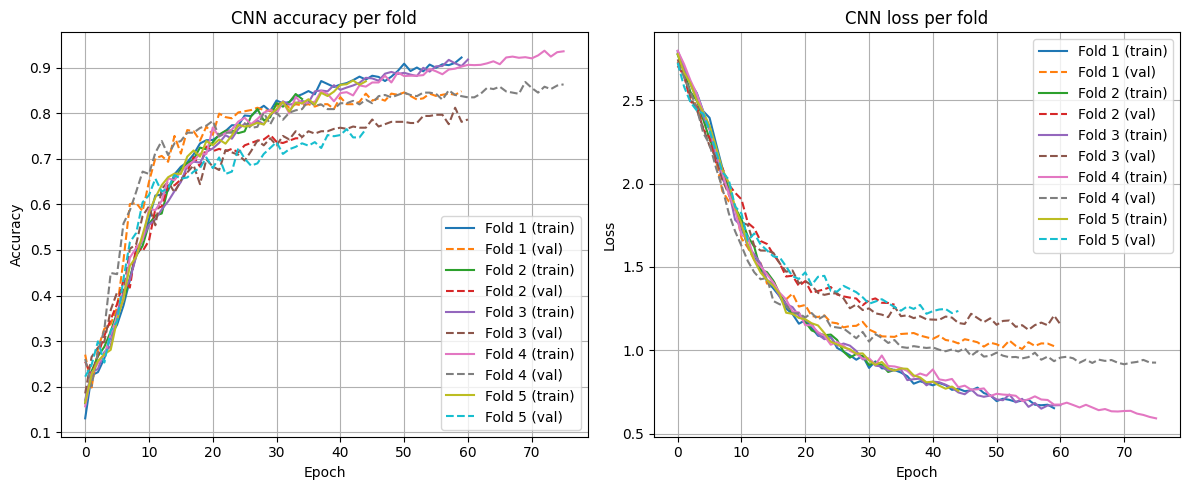

In [28]:
display_kfold_train_val_results(cnn_history_list, 'CNN')

La cross validation, que j'ai réalisée avec un KFold stratifiée pour prendre en compte les classes déséquilibrées, vient confirmer tout ça. Malgré le petit jeu de données, on parvient quand même à obtenir un modèle à peu près stable

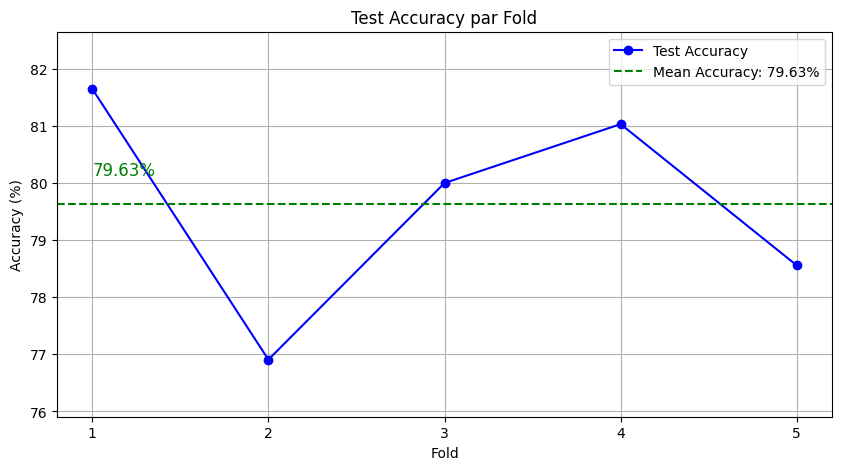

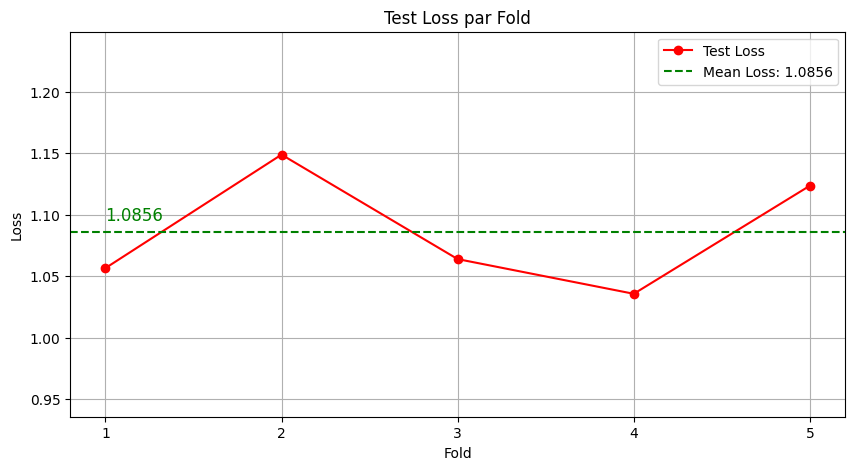

Overall accuracy: 79.63 ± 1.72 %
Overall loss: 1.09 ± 0.04


In [100]:
display_kfold_test_results(cnn_test_scores)

On a un modèle qui généralise bien correctement avec une bonne précision de 80% et une faible perte de 1.

## RESNET


### Build and train model

In [66]:
# Define the ResNet architecture
def residual_module(input,channels):
  """Define the residual module for the resnet model.

  Parameters
  ----------
  input : Tensor
    The input tensor for the residual module.
  channels : int
    The number of channels for the residual module.

  Returns
  -------
  Tensor
    The output tensor of the residual module.
  """
  stride=1
  kernel_size=3
  x_shortcut = input
  x = BatchNormalization()(input)
  x = Activation('relu')(x)
  x = Conv1D(channels, (1), kernel_regularizer=l2(0.01))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(channels, kernel_size, padding='same', strides=stride, kernel_regularizer=l2(0.01))(x)
  output = Add()([x, x_shortcut])
  output = Dropout(0.4)(output) # regularization
  return(output)

# Define the ResNet architecture
def resnet():
    """Create a ResNet for classification.

    Returns
    -------
    Sequential
      The compiled Keras Sequential model.
    """
    n_residual = 2  # Number of residual modules in the network
    print("Simple residual network with {} modules".format(n_residual))

    # Define the input layer with the shape (400 time steps, 20 features)
    inputs = Input(shape=(400, 20))

    # Pass the input through the residual blocks
    residual_i = inputs # residuel = input valeur initiale
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)  # Each residual block has 20 filters
        residual_i = MaxPooling1D(pool_size=2, strides=2)(residual_i)

    # Apply global average pooling (1D) with a pooling size of 2 and stride of 1
    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)

    # Flatten the output to prepare it for the fully connected (Dense) layer
    flat_1 = Flatten()(gavg_1)

    # Dense output layer with 10 neurons (for 3 output classes) and softmax activation
    # Softmax is used for multi-class classification, providing probability distribution over the classes
    output = Dense(10, activation="softmax")(flat_1)

    # Define the model by specifying the inputs and outputs
    model = Model(inputs=inputs, outputs=output)
    opt = optimizers.Adam(learning_rate=0.00005)
    # Compile the model with Adam optimizer and categorical crossentropy loss (for multi-class classification)
    # The 'accuracy' metric will be used to monitor the model's performance during training
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

In [67]:
# Create the ResNet model
resnet_model = resnet()
# Visualize the model architecture, saving it to a file
plot_model(resnet_model, to_file="residual.png", show_shapes=True, show_layer_names=True)
# Print the summary of the model architecture
print(resnet_model.summary())

Simple residual network with 2 modules


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_64    │ (None, 400, 20)        │             80 │ input_layer_17[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 400, 20)        │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_58 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_40[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_65    │ (None, 400, 20)        │             80 │ conv1d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_41             │ (None, 400, 20)        │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_59 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_41[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 400, 20)        │              0 │ conv1d_59[0][0],       │
│                           │                        │                │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_50 (Dropout)      │ (None, 400, 20)        │              0 │ add_20[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_20          │ (None, 200, 20)        │              0 │ dropout_50[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_66    │ (None, 200, 20)        │             80 │ max_pooling1d_20[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_42             │ (None, 200, 20)        │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_60 (Conv1D)        │ (None, 200, 20)        │            420 │ activation_42[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_67    │ (None, 200, 20)        │             80 │ conv1d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_43        

 Total params: 23,410 (91.45 KB)

 Trainable params: 23,250 (90.82 KB)

 Non-trainable params: 160 (640.00 B)

None


In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_resnet = resnet_model.fit(X_train, y_train_oh, validation_split=0.2, epochs=200, batch_size=64, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.0931 - loss: 4.0705 - weighted_accuracy: 0.0999 - val_accuracy: 0.1082 - val_loss: 3.1215 - val_weighted_accuracy: 0.1082
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1121 - loss: 3.8844 - weighted_accuracy: 0.1222 - val_accuracy: 0.1211 - val_loss: 3.1004 - val_weighted_accuracy: 0.1211
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1087 - loss: 3.7585 - weighted_accuracy: 0.1022 - val_accuracy: 0.1186 - val_loss: 3.0810 - val_weighted_accuracy: 0.1186
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1276 - loss: 3.6543 - weighted_accuracy: 0.1237 - val_accuracy: 0.1314 - val_loss: 3.0613 - val_weighted_accuracy: 0.1314
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1306 - loss: 3.5210 - weighted_accuracy: 0.1380 - val_accuracy: 0.1521 - val_loss: 3.0324 - val_weighted_accuracy: 0.1521
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

In [69]:
resnet_scores = resnet_model.evaluate(X_test, y_test_oh)
print("Neural network accuracy: %.2f%%" % (resnet_scores[1] * 100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6998 - loss: 1.6739 - weighted_accuracy: 0.6998
Neural network accuracy: 70.93%


 Les performances en généralisation sont acceptables avec une accuracy plutôt correcte de 70% et une loss de 1.7.

### Performances

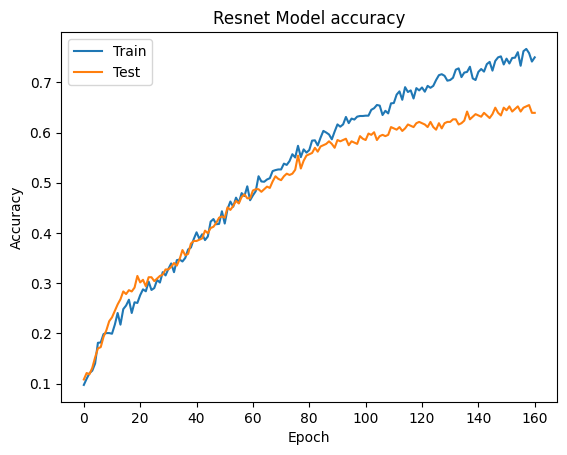

In [70]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Resnet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

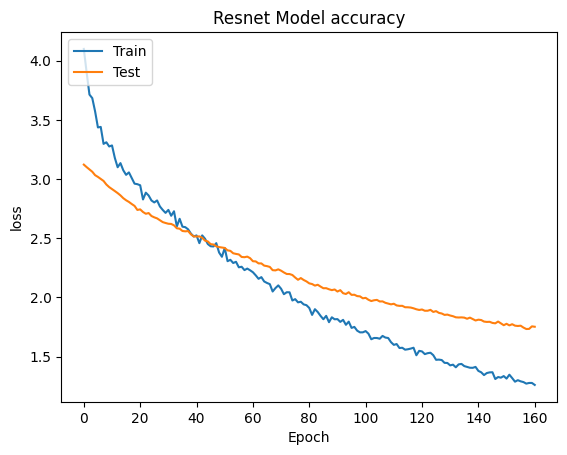

In [71]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Resnet Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Voici les résultats que j'obtiens avec un earlyStopping. Le modèle a du mal à converger et finit par over fitter malgré tout.

In [94]:
y_predresnet = resnet_model.predict(X_test)
y_predresnet_classes = np.argmax(y_predresnet, axis = 1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


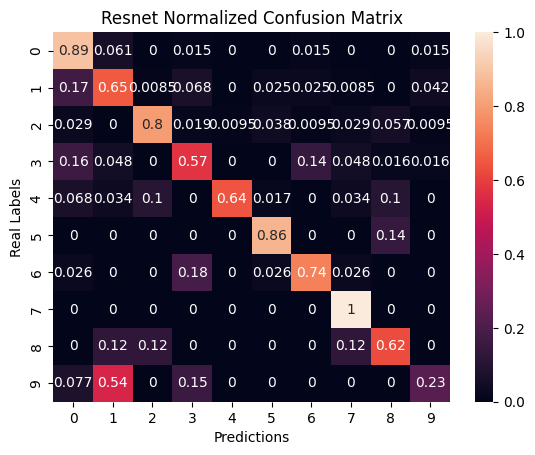

In [97]:
sns.heatmap(confusion_matrix(y_test, y_predresnet_classes, normalize="true"), annot=True)
plt.title("Resnet Normalized Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Labels")
plt.show()

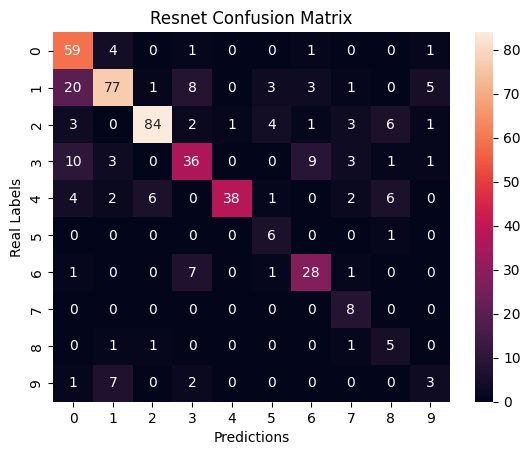

In [98]:
sns.heatmap(confusion_matrix(y_test, y_predresnet_classes), annot=True, fmt='d')
plt.title("Resnet Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Labels")
plt.show()

Ici encore les classes sous-représentées dans le jeu de données sont beaucoup moins bien prédites que les autres

### Cross Validation

In [83]:
def resnet_cv():
  """Compute cross-validation for the ResNet model.

  Returns
  -------
  Tuple[int, int]
    A tuple containing the history list and test scores for each fold.
  """
  history_list  = []
  test_scores = []
  # StratifiedKFold for class proportions
  skf = StratifiedKFold(n_splits=5, shuffle=True)
  # for each fold
  for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_oh[train_index], y_train_oh[val_index]
    # build the model
    model = resnet()
    # training
    print(f'\n========== FOLD {fold} ==========\n')
    history = model.fit(x_train_fold, y_train_fold, validation_data=(x_val_fold, y_val_fold), epochs=120, batch_size=64, class_weight=class_weights)
    # Store results
    history_list.append(history.history)
    test_scores.append(model.evaluate(X_test, y_test_oh, verbose=0))
  return history_list, test_scores

In [84]:
resnet_history_list, resnet_test_scores = resnet_cv()

Simple residual network with 2 modules

========== FOLD 1 ==========

Epoch 1/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - accuracy: 0.0649 - loss: 5.2759 - weighted_accuracy: 0.1000 - val_accuracy: 0.0825 - val_loss: 3.0979 - val_weighted_accuracy: 0.0825
Epoch 2/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0787 - loss: 4.5050 - weighted_accuracy: 0.0995 - val_accuracy: 0.1134 - val_loss: 3.0810 - val_weighted_accuracy: 0.1134
Epoch 3/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0854 - loss: 4.1714 - weighted_accuracy: 0.0791 - val_accuracy: 0.1186 - val_loss: 3.0703 - val_weighted_accuracy: 0.1186
Epoch 4/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1047 - loss: 3.7565 - weighted_accuracy: 0.1060 - val_accuracy: 0.1211 - val_loss: 3.0545 - val_weighted_accuracy: 0.1211
Epoch 5/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1278 - loss: 3.8433 - weighted_accuracy: 0.1259 - val_accuracy: 0.1263 - val_loss: 3.0440 - val_weighted_accuracy:

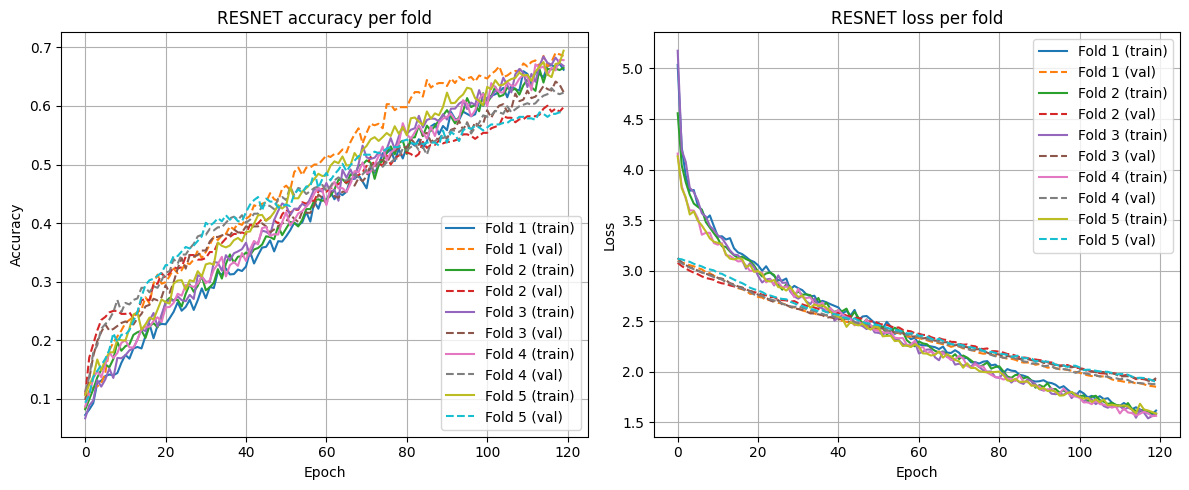

In [85]:
display_kfold_train_val_results(resnet_history_list, 'RESNET')

Toutefois, la Kfold stratifiée montre que le modèle reste malgré tout relativement stable.

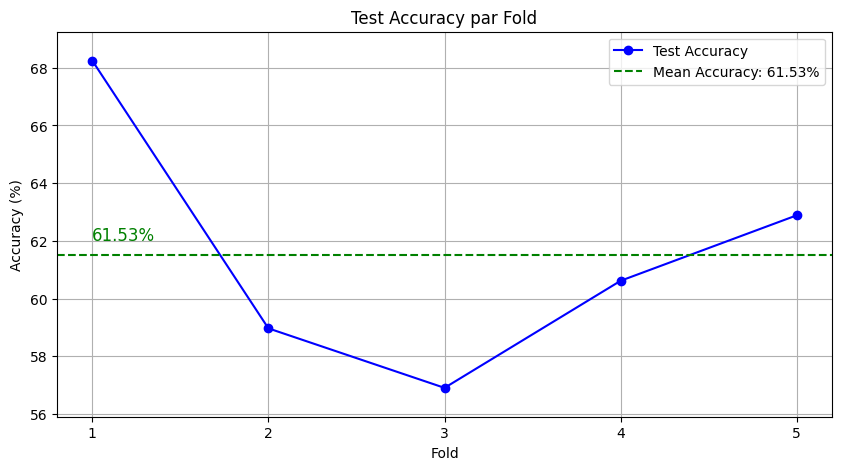

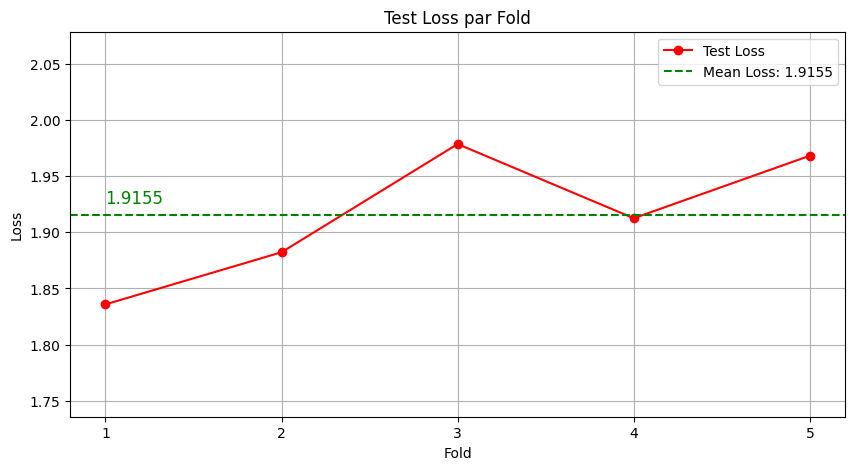

Overall accuracy: 61.53 ± 3.89 %
Overall loss: 1.92 ± 0.05


In [101]:
display_kfold_test_results(resnet_test_scores)

Mais les performances de notre modèle sont en réalité moins bonnes que celles de notre premier entraînement: le modèle sur-apprend et a du mal à généraliser avec une accuracy de 61% et une loss de presque 2 pour les jeux de test.

## Conclusion

| **Métrique**            | **CNN** | **RESNET** |
|-------------------------|---------|------------|
| Accuracy (%)            | 79.63   | 61.53      |
| Loss                    | 1.09    | 1.92       |
| Temps d'exécution (s)   | ~42     | ~213       |

Finalement on se rend compte que le RESNET, malgré le fait qu'il soit plus profond, n'a pas plus aidé pour notre problème de classification de séquences protéiques en localisations subcellulaires. Le CNN reste malgré tout meilleur que ce soit en précision, en perte ou en temps d'exécution.